# Study of [EPIC210363145](https://exofop.ipac.caltech.edu/k2/edit_target.php?id=210363145)

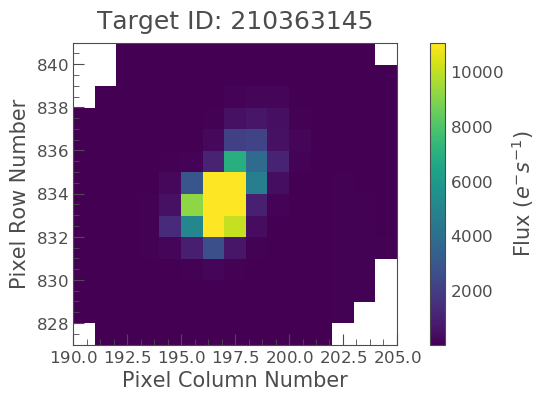

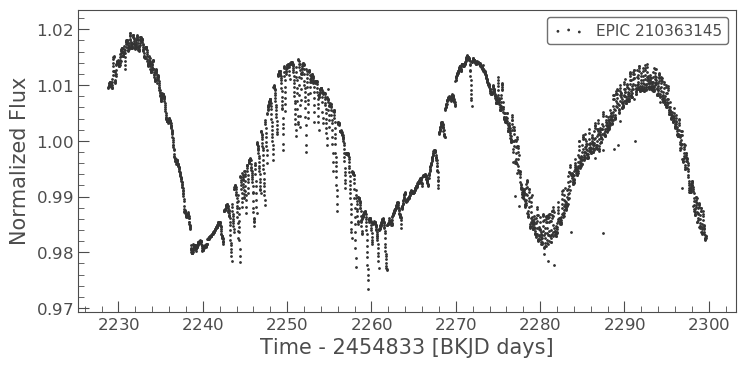

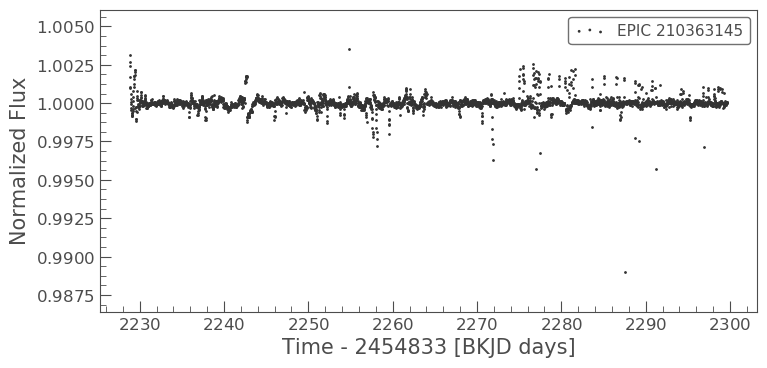

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '210363145'

tpf = search_targetpixelfile(target).download()
tpf.plot()
lc = search_lightcurvefile(target).download().PDCSAP_FLUX.remove_nans()
lc.scatter()
corr_lc = lc.to_corrector("sff").correct(windows=10)
corr_lc.scatter()

Best Fit Period: 8.3900 days


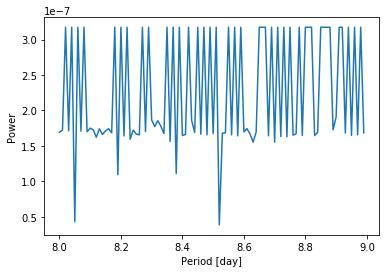

In [13]:
from astropy.stats import BoxLeastSquares
import matplotlib.pyplot as plt

bls = BoxLeastSquares(corr_lc.time, corr_lc.flux, corr_lc.flux_err)
periods = np.arange(8, 9, 0.01)
durations = np.arange(0.005, 0.15, 0.001)
periodogram = bls.power(periods, durations)

plt.plot(periodogram.period, periodogram.power)
plt.ylabel("Power")
plt.xlabel("Period [day]");

period = periods[np.argmax(periodogram.power)]
print('Best Fit Period: {:0.4f} days'.format(period))

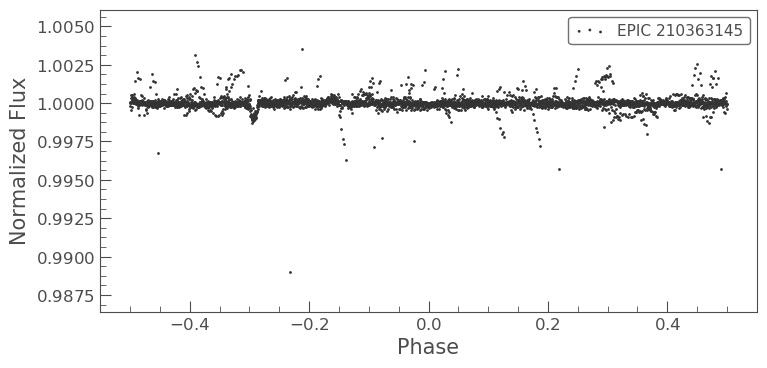

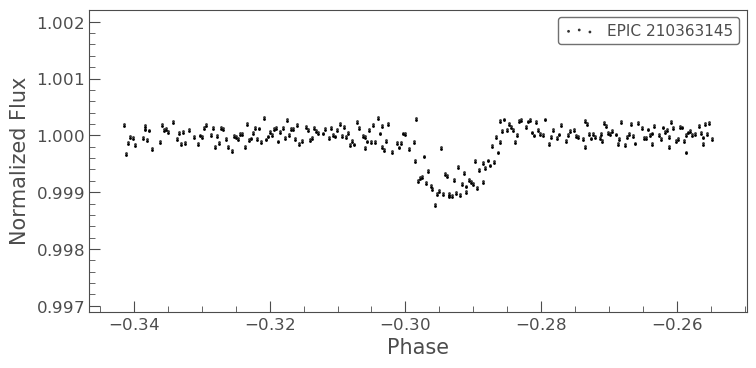

In [10]:
period_f = 8.200750000
lcf = corr_lc.fold(period=period_f,t0=1.4)
lcf.scatter()
lc_transit = lcf[500:800].normalize().remove_outliers(sigma_upper=1)
lc_transit.scatter()
lcf.time_format = 'jd'
period_f
plt.scatter(lc_transit.time, lc_transit.flux, s=1, c='k')
plt.savefig('transit.png')

In [11]:
import math

R_star = 0.83 # in sun's radius
R_star = R_star * 695510000 # in meter

Td_values = lc_transit.time[lc_transit.flux < 0.9995]
Td = Td_values[-1] - Td_values[0]

min_tr = lc_transit.flux[lc_transit.flux < 0.9992].mean()
R_planet = math.sqrt(1-min_tr)*R_star
R_planet = R_planet / 69911000 # in jupiter's radius

Td , R_planet*11.2

(0.010581819527033076, 2.885698145702906)